In [1]:
import numpy as np
import zipfile
from datasets import Dataset
import pandas as pd

import os
# run as much as possible accelerated by apple silicon, fall back to cpu if not possible
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch

import sys
sys.path.append('..')
from scripts.audio import audio_file_to_array
from scripts.ipa import timit2ipa
from scripts.ipa import filter_chars

/home/arunasri/ML/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys, os
sys.path.append('..')
from scripts.eval_tests.panphon_model_eval import panphon_model_eval 

In [3]:
# set espeak library path for macOS
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

In [4]:
from transformers import AutoProcessor, AutoModelForCTC, AutoTokenizer, AutoFeatureExtractor

# Load Data

In [5]:
timit = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
timit_files = timit.namelist()

In [6]:

test_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TEST'), timit_files))))

In [7]:
WAV_HEADER_SIZE = 44
def zipped_wav_to_array(filename):
    with timit.open(filename) as wav_file:
        return np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]

In [8]:
# First, ensure that the simplify_timit function is available and works
def simplify_timit(phoneme):
    # Substitute the phoneme based on the dictionary
    substitution_dict = {
        'ɾ̃': 'ɾ',  # Replace nasalized flap with plain flap
        'ŋ̍': 'ŋ',  # Remove syllabic marker from 'ŋ̍'
        'ə̥': 'ə',  # Remove voiceless marker from 'ə̥'
        'ɝ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'ɚ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'l̩': 'l',   # Remove syllabic marker from 'l̩'
        'm̩': 'm',   # Remove syllabic marker from 'm̩'
        'n̩': 'n',   # Remove syllabic marker from 'n̩'
        '̩': '',     # Remove syllabic marker
        'ʉ': 'u',    # Replace high central rounded vowel with high back rounded vowel
        'ɨ': 'i',    # Replace high central unrounded vowel with high front unrounded vowel
        ' ': '',     # Remove nasalization marker
        'ɦ': 'h',    # Replace voiceless glottal fricative with voiceless glottal fricative
        '͡': '', # Simplify affricate to single character
        # Add other necessary substitutions if needed
    }
    phoneme.replace('͡', '') 
    # Apply the substitution for the phoneme
    return substitution_dict.get(phoneme, phoneme)  # Return simplified phoneme or the original if no replacement

def remove_stress_mark(text):
    """
    Removes the combining double inverted breve (͡) from text.
    
    Args:
        text: String or iterable containing IPA symbols
        
    Returns:
        Text with stress marks removed
    """
    if isinstance(text, str):
        return text.replace('͡', '')
    else:
        raise TypeError("Input must be string, set, or list")
    
# Updated timit_file_to_dict to use the simplified IPA phonemes
def timit_file_to_dict(filename):
    with timit.open(filename + '.PHN') as phn_file:
        timestamped_phonemes = []
        for line in phn_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, phoneme = line.split()
            
            # Convert to IPA first and then simplify the phoneme
            ipa_phonemes = timit2ipa(phoneme, "eng")
            
            # Now filter only the necessary characters (this simplifies the phoneme to the basic form)
            cleaned_ipa = filter_chars(simplify_timit(ipa_phonemes), filter_type="letters")
            cleaned_ipa = remove_stress_mark(cleaned_ipa)
            timestamped_phonemes.append((cleaned_ipa, int(start), int(end)))

    return {'timestamped_phonemes': timestamped_phonemes, 'wav_filename': filename + '.WAV'}

# Updated files_to_df to create DataFrame with cleaned-up phonemes
def files_to_df(files):
    records = []
    for filename in files:
        parsed = timit_file_to_dict(filename)
        parsed['audio'] = zipped_wav_to_array(parsed['wav_filename'])
        del parsed['wav_filename']
        parsed['ipa'] = "".join(phoneme for phoneme, _, _ in parsed['timestamped_phonemes'])
        parsed['phoneme_starts'] = [start for _, start, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_ends'] = [end for _, _, end in parsed['timestamped_phonemes']]
        del parsed['timestamped_phonemes']
        records.append(parsed)
    return pd.DataFrame(records)

# Call files_to_df for your test files
test_df = files_to_df(test_files)
test_df.head()


,audio,ipa,phoneme_starts,phoneme_ends
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃihæddʒɹdɑɹksuʔɪnɡɹisiwɔʃwɔɾɹɔjɪɹ,"[0, 2534, 4440, 5400, 5848, 8040, 8712, 9320, ...","[2534, 4440, 5400, 5848, 8040, 8712, 9320, 106..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",oʊnʔæskmitəkɛɹiinʔɔliɹæɡlaɪkðæt,"[0, 2190, 2650, 5240, 5880, 6379, 9030, 10820,...","[2190, 2650, 5240, 5880, 6379, 9030, 10820, 11..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʔɑɹjəlʊkiŋfɔɹəmplɔɪmənt,"[0, 1963, 2464, 3578, 4135, 4971, 5806, 6516, ...","[1963, 2464, 3578, 4135, 4971, 5806, 6516, 764..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",əmbaɪnʔɔlðiiŋɡɹiɾiinsiɾəlɑɹddʒboʊl,"[0, 2180, 2940, 3424, 4796, 5547, 5726, 9960, ...","[2180, 2940, 3424, 4796, 5547, 5726, 9960, 105..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðɛnhiðɛnwʌt,"[0, 2200, 2597, 4600, 5430, 6558, 9357, 19270,...","[2200, 2597, 4600, 5430, 6558, 9357, 19270, 19..."


In [9]:
timit_vocab = set("".join(test_df['ipa']))
print(f"Number of unique IPA symbols in TIMIT: {(timit_vocab)}")

Number of unique IPA symbols in TIMIT: {'e', 'd', 'ŋ', 'ɹ', 'ɔ', 'u', 'l', 'v', 'æ', 's', 'ɪ', 'n', 'ə', 't', 'f', 'ʊ', 'ɡ', 'a', 'ʒ', 'm', 'ɾ', 'k', 'z', 'o', 'h', 'ɛ', 'ʃ', 'ʌ', 'i', 'j', 'p', 'ʔ', 'b', 'ɑ', 'θ', 'ð', 'w'}


### Cleaning Up Audio

In [10]:
def crop_audio(row):
    # Access the phoneme_starts column and get the last value of the list
    end = row['phoneme_starts'][-1]
    # Access the phoneme_ends column and get the first value of the list
    start = row['phoneme_ends'][0]
    # Crop the audio from start to end
    # note that start and end are in samples, not seconds
    cropped_audio = row['audio'][start:end]
    
    return cropped_audio

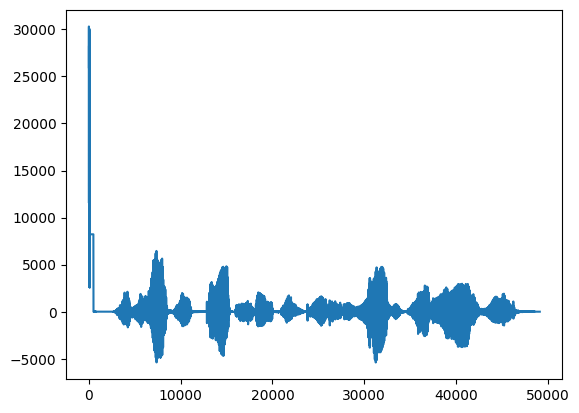

In [11]:
# graph one audio to see start signal that we will remove
import matplotlib.pyplot as plt
plt.plot(test_df['audio'][0])
plt.show()

In [12]:
test_df['cropped_audio'] = test_df.apply(crop_audio, axis=1)
test_df.head()

,audio,ipa,phoneme_starts,phoneme_ends,cropped_audio
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃihæddʒɹdɑɹksuʔɪnɡɹisiwɔʃwɔɾɹɔjɪɹ,"[0, 2534, 4440, 5400, 5848, 8040, 8712, 9320, ...","[2534, 4440, 5400, 5848, 8040, 8712, 9320, 106...","[0, 0, 0, 0, 1, 1, 0, 2, 4, -3, 1, 0, 0, 3, 0,..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",oʊnʔæskmitəkɛɹiinʔɔliɹæɡlaɪkðæt,"[0, 2190, 2650, 5240, 5880, 6379, 9030, 10820,...","[2190, 2650, 5240, 5880, 6379, 9030, 10820, 11...","[4, 2, 0, 0, 2, 2, 1, 2, 4, 3, 3, 3, 1, 2, 1, ..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʔɑɹjəlʊkiŋfɔɹəmplɔɪmənt,"[0, 1963, 2464, 3578, 4135, 4971, 5806, 6516, ...","[1963, 2464, 3578, 4135, 4971, 5806, 6516, 764...","[-1, 2, 0, -1, 1, 0, 1, 3, 1, 0, 1, -2, -1, 1,..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",əmbaɪnʔɔlðiiŋɡɹiɾiinsiɾəlɑɹddʒboʊl,"[0, 2180, 2940, 3424, 4796, 5547, 5726, 9960, ...","[2180, 2940, 3424, 4796, 5547, 5726, 9960, 105...","[2, 1, 0, 3, 0, 5, 1, 3, 2, 1, 3, 1, 0, 2, 0, ..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðɛnhiðɛnwʌt,"[0, 2200, 2597, 4600, 5430, 6558, 9357, 19270,...","[2200, 2597, 4600, 5430, 6558, 9357, 19270, 19...","[-22, -22, -19, -20, -19, -12, -11, -2, 21, 31..."


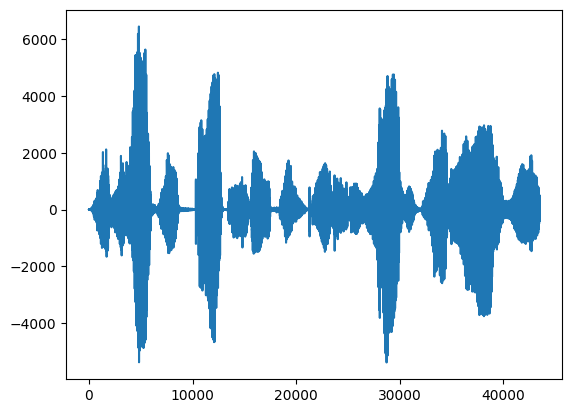

In [13]:
# visualize again, much better!
plt.plot(test_df['cropped_audio'][0])


In [14]:
# Same for test_df
test_df = test_df.drop(columns=['phoneme_starts', 'phoneme_ends', 'audio'])
test_df = test_df.rename(columns={'cropped_audio': 'audio'})
test_df.head()

,ipa,audio
0,ʃihæddʒɹdɑɹksuʔɪnɡɹisiwɔʃwɔɾɹɔjɪɹ,"[0, 0, 0, 0, 1, 1, 0, 2, 4, -3, 1, 0, 0, 3, 0,..."
1,oʊnʔæskmitəkɛɹiinʔɔliɹæɡlaɪkðæt,"[4, 2, 0, 0, 2, 2, 1, 2, 4, 3, 3, 3, 1, 2, 1, ..."
2,ʔɑɹjəlʊkiŋfɔɹəmplɔɪmənt,"[-1, 2, 0, -1, 1, 0, 1, 3, 1, 0, 1, -2, -1, 1,..."
3,əmbaɪnʔɔlðiiŋɡɹiɾiinsiɾəlɑɹddʒboʊl,"[2, 1, 0, 3, 0, 5, 1, 3, 2, 1, 3, 1, 0, 2, 0, ..."
4,ðɛnhiðɛnwʌt,"[-22, -22, -19, -20, -19, -12, -11, -2, 21, 31..."


In [15]:

test_ds = Dataset.from_pandas(test_df)

## retrieve the Total TIMIT Vocab 
we will grab the set of unique timit phonemes and map them to IPA. this will be the vocab all models will be adjusted to fit

In [16]:
PRE_TRAINED_ID = "facebook/wav2vec2-lv-60-espeak-cv-ft"

In [ ]:
processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)
model = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID).to('cuda')
BATCH_SIZE = 1

# Tokenize!

In [18]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_ID)
vocab = tokenizer.get_vocab()
print(vocab)

{'<s>': 1, '<pad>': 0, '</s>': 2, '<unk>': 3, 'n': 4, 's': 5, 't': 6, 'ə': 7, 'l': 8, 'a': 9, 'i': 10, 'k': 11, 'd': 12, 'm': 13, 'ɛ': 14, 'ɾ': 15, 'e': 16, 'ɪ': 17, 'p': 18, 'o': 19, 'ɐ': 20, 'z': 21, 'ð': 22, 'f': 23, 'j': 24, 'v': 25, 'b': 26, 'ɹ': 27, 'ʁ': 28, 'ʊ': 29, 'iː': 30, 'r': 31, 'w': 32, 'ʌ': 33, 'u': 34, 'ɡ': 35, 'æ': 36, 'aɪ': 37, 'ʃ': 38, 'h': 39, 'ɔ': 40, 'ɑː': 41, 'ŋ': 42, 'ɚ': 43, 'eɪ': 44, 'β': 45, 'uː': 46, 'y': 47, 'ɑ̃': 48, 'oʊ': 49, 'ᵻ': 50, 'eː': 51, 'θ': 52, 'aʊ': 53, 'ts': 54, 'oː': 55, 'ɔ̃': 56, 'ɣ': 57, 'ɜ': 58, 'ɑ': 59, 'dʒ': 60, 'əl': 61, 'x': 62, 'ɜː': 63, 'ç': 64, 'ʒ': 65, 'tʃ': 66, 'ɔː': 67, 'ɑːɹ': 68, 'ɛ̃': 69, 'ʎ': 70, 'ɔːɹ': 71, 'ʋ': 72, 'aː': 73, 'ɕ': 74, 'œ': 75, 'ø': 76, 'oːɹ': 77, 'ɲ': 78, 'yː': 79, 'ʔ': 80, 'iə': 81, 'i5': 82, 's.': 83, 'tɕ': 84, '??': 85, 'nʲ': 86, 'ɛː': 87, 'œ̃': 88, 'ɭ': 89, 'ɔø': 90, 'ʑ': 91, 'tʲ': 92, 'ɨ': 93, 'ɛɹ': 94, 'ts.': 95, 'rʲ': 96, 'ɪɹ': 97, 'ɭʲ': 98, 'i.5': 99, 'ɔɪ': 100, 'q': 101, 'sʲ': 102, 'u5': 103, 'ʊɹ': 104

In [19]:
timit_vocab = set("".join(test_df['ipa']))

In [20]:
# add missing symbols to the vocab
missing_symbols = timit_vocab - set(vocab.keys())
print("missing: ", missing_symbols)
tokenizer.add_tokens(list(missing_symbols))
vocab = tokenizer.get_vocab()
missing_symbols = timit_vocab - set(vocab.keys())
# assert missing is empty
assert len(missing_symbols) == 0
print(vocab)


missing:  set()
{'<s>': 1, '<pad>': 0, '</s>': 2, '<unk>': 3, 'n': 4, 's': 5, 't': 6, 'ə': 7, 'l': 8, 'a': 9, 'i': 10, 'k': 11, 'd': 12, 'm': 13, 'ɛ': 14, 'ɾ': 15, 'e': 16, 'ɪ': 17, 'p': 18, 'o': 19, 'ɐ': 20, 'z': 21, 'ð': 22, 'f': 23, 'j': 24, 'v': 25, 'b': 26, 'ɹ': 27, 'ʁ': 28, 'ʊ': 29, 'iː': 30, 'r': 31, 'w': 32, 'ʌ': 33, 'u': 34, 'ɡ': 35, 'æ': 36, 'aɪ': 37, 'ʃ': 38, 'h': 39, 'ɔ': 40, 'ɑː': 41, 'ŋ': 42, 'ɚ': 43, 'eɪ': 44, 'β': 45, 'uː': 46, 'y': 47, 'ɑ̃': 48, 'oʊ': 49, 'ᵻ': 50, 'eː': 51, 'θ': 52, 'aʊ': 53, 'ts': 54, 'oː': 55, 'ɔ̃': 56, 'ɣ': 57, 'ɜ': 58, 'ɑ': 59, 'dʒ': 60, 'əl': 61, 'x': 62, 'ɜː': 63, 'ç': 64, 'ʒ': 65, 'tʃ': 66, 'ɔː': 67, 'ɑːɹ': 68, 'ɛ̃': 69, 'ʎ': 70, 'ɔːɹ': 71, 'ʋ': 72, 'aː': 73, 'ɕ': 74, 'œ': 75, 'ø': 76, 'oːɹ': 77, 'ɲ': 78, 'yː': 79, 'ʔ': 80, 'iə': 81, 'i5': 82, 's.': 83, 'tɕ': 84, '??': 85, 'nʲ': 86, 'ɛː': 87, 'œ̃': 88, 'ɭ': 89, 'ɔø': 90, 'ʑ': 91, 'tʲ': 92, 'ɨ': 93, 'ɛɹ': 94, 'ts.': 95, 'rʲ': 96, 'ɪɹ': 97, 'ɭʲ': 98, 'i.5': 99, 'ɔɪ': 100, 'q': 101, 'sʲ': 102, 'u5'

# Update Feature Extraction

In [21]:
feature_extractor = AutoFeatureExtractor.from_pretrained(PRE_TRAINED_ID)

We don't need to update the feature extractor since it has been pretrained on 16kHz audio which matches the TIMIT dataset.

For datasets with different sampling rates, the feature extractor should be updated or the audio resampled (easier).

This is also where code to add extra features (such as conditioning on speaker's native language etc.) would be added.

# Preprocess Data

In [22]:
test_df.head()

,ipa,audio
0,ʃihæddʒɹdɑɹksuʔɪnɡɹisiwɔʃwɔɾɹɔjɪɹ,"[0, 0, 0, 0, 1, 1, 0, 2, 4, -3, 1, 0, 0, 3, 0,..."
1,oʊnʔæskmitəkɛɹiinʔɔliɹæɡlaɪkðæt,"[4, 2, 0, 0, 2, 2, 1, 2, 4, 3, 3, 3, 1, 2, 1, ..."
2,ʔɑɹjəlʊkiŋfɔɹəmplɔɪmənt,"[-1, 2, 0, -1, 1, 0, 1, 3, 1, 0, 1, -2, -1, 1,..."
3,əmbaɪnʔɔlðiiŋɡɹiɾiinsiɾəlɑɹddʒboʊl,"[2, 1, 0, 3, 0, 5, 1, 3, 2, 1, 3, 1, 0, 2, 0, ..."
4,ðɛnhiðɛnwʌt,"[-22, -22, -19, -20, -19, -12, -11, -2, 21, 31..."


In [23]:
print(test_df['audio'][1])

[  4   2   0 ... -67 -64 -54]


# Run Evaluation

In [24]:
print(tokenizer.get_vocab())  # This will print the vocabulary, including the newly added token


{'<s>': 1, '<pad>': 0, '</s>': 2, '<unk>': 3, 'n': 4, 's': 5, 't': 6, 'ə': 7, 'l': 8, 'a': 9, 'i': 10, 'k': 11, 'd': 12, 'm': 13, 'ɛ': 14, 'ɾ': 15, 'e': 16, 'ɪ': 17, 'p': 18, 'o': 19, 'ɐ': 20, 'z': 21, 'ð': 22, 'f': 23, 'j': 24, 'v': 25, 'b': 26, 'ɹ': 27, 'ʁ': 28, 'ʊ': 29, 'iː': 30, 'r': 31, 'w': 32, 'ʌ': 33, 'u': 34, 'ɡ': 35, 'æ': 36, 'aɪ': 37, 'ʃ': 38, 'h': 39, 'ɔ': 40, 'ɑː': 41, 'ŋ': 42, 'ɚ': 43, 'eɪ': 44, 'β': 45, 'uː': 46, 'y': 47, 'ɑ̃': 48, 'oʊ': 49, 'ᵻ': 50, 'eː': 51, 'θ': 52, 'aʊ': 53, 'ts': 54, 'oː': 55, 'ɔ̃': 56, 'ɣ': 57, 'ɜ': 58, 'ɑ': 59, 'dʒ': 60, 'əl': 61, 'x': 62, 'ɜː': 63, 'ç': 64, 'ʒ': 65, 'tʃ': 66, 'ɔː': 67, 'ɑːɹ': 68, 'ɛ̃': 69, 'ʎ': 70, 'ɔːɹ': 71, 'ʋ': 72, 'aː': 73, 'ɕ': 74, 'œ': 75, 'ø': 76, 'oːɹ': 77, 'ɲ': 78, 'yː': 79, 'ʔ': 80, 'iə': 81, 'i5': 82, 's.': 83, 'tɕ': 84, '??': 85, 'nʲ': 86, 'ɛː': 87, 'œ̃': 88, 'ɭ': 89, 'ɔø': 90, 'ʑ': 91, 'tʲ': 92, 'ɨ': 93, 'ɛɹ': 94, 'ts.': 95, 'rʲ': 96, 'ɪɹ': 97, 'ɭʲ': 98, 'i.5': 99, 'ɔɪ': 100, 'q': 101, 'sʲ': 102, 'u5': 103, 'ʊɹ': 104

In [25]:
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from audiomentations import (
    Compose, AddGaussianNoise, TimeStretch, 
    PitchShift, ApplyImpulseResponse, BandPassFilter, AddBackgroundNoise
)
from pathlib import Path

def evaluate_model(test_df, processor, model):
    def collate_fn(batch):
        """
        Collate function to batch inputs and process them with augmentation.
        """
        # Process both original and augmented audio
        original_audios = []
        augmented_audios = []
        labels = []
        
        for item in batch:
            # Convert original audio to numpy if it isn't already
            original_audio_np = np.array(item['audio'], dtype=np.float32)
            original_audio = torch.tensor(original_audio_np, dtype=torch.float32)
            original_audios.append(original_audio)

            augment = Compose([
                # PitchShift(
                #     min_semitones=-4,
                #     max_semitones=4,
                #     p=1.0  # Set to 1.0 for testing
                # ),
                TimeStretch(
                        min_rate=0.8,
                        max_rate=1.00,
                        p=1.0, 
                        leave_length_unchanged=False
                ),
                # BandPassFilter( min_center_freq=100.0, max_center_freq=6000, p=1.0)
                # AddBackgroundNoise(
                #     sounds_path=str("/home/arunasri/ML/notebooks/noise_samples/emo-soundscape/test"),
                #     min_snr_db=3.0,
                #     max_snr_db=10.0,
                #     p=1.0
                # ),
                # ApplyImpulseResponse(
                #     ir_path=str("/home/arunasri/ML/notebooks/noise_samples/real_rirs_isotropic_noises/test"),
                #     p=1.0
                # )
            ])
            # Make sure input to augment is numpy array
            augmented = augment(samples=original_audio_np, sample_rate=16000)
            augmented_audio = torch.tensor(augmented, dtype=torch.float32)
            augmented_audios.append(augmented_audio)
            
            # Add labels twice (once for original, once for augmented)
            labels.extend([item['ipa']])

        # Combine and pad all audio sequences
        all_audios = augmented_audios
        padded_audios = pad_sequence(all_audios, batch_first=True, padding_value=-100)

        # Process through feature extractor
        inputs = processor.feature_extractor(
            padded_audios.numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            padding=False
        )

        return {
            "input_values": inputs["input_values"],
            "attention_mask": inputs.get("attention_mask"),
            "labels": labels,
        }

    dataset = test_df.to_dict(orient="records")
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=4, pin_memory=True)

    model.eval().to('cuda')
    weighted_distances = []
    total_cer = []
    
    for batch in data_loader:
        input_values = batch["input_values"].to('cuda', non_blocking=True)
        # attention_mask = batch["attention_mask"].to('cuda', non_blocking=True)
        ground_truth_labels = batch["labels"]
        
        input_values = input_values.to(model.device)

        with torch.no_grad():
            outputs = model(input_values=input_values)
            logits = outputs.logits
            
            predicted_ids = torch.argmax(logits, dim=-1)
            try:
                predictions = processor.batch_decode(predicted_ids, skip_special_tokens=True)
                if not predictions:  # Skip if predictions is empty
                    continue
                predictions = [pred.replace(' ', '') for pred in predictions]

                # Call panphon_model_eval with label and predicted IPA
                results = panphon_model_eval(ground_truth_labels, predictions)
                
                weighted_distances.append(results['weighted_feature_dist'])
                total_cer.append(results['cer_score'])

                print(f"Weighted feature edit distance: {results['weighted_feature_dist']}")
                print(f"CER: {results['cer_score']}")
            except ValueError:  # Skip if batch_decode fails
                print("Batch decode failed")
                continue

    weighted_distances = np.array(weighted_distances)
    avg_weighted_dist = np.mean(weighted_distances)
    std_weighted_dist = np.std(weighted_distances)

    avg_cer = np.mean(total_cer)
    std_cer = np.std(total_cer)

    return avg_weighted_dist, std_weighted_dist, avg_cer, std_cer

# Evaluate the model
avg_distance, std_distance, avg_cer, std_cer = evaluate_model(test_df, processor, model)
print(f"Final Results - Average Weighted Distance: {avg_distance}, Standard Deviation: {std_distance}")
print(f"Final Results - Average CER: {avg_cer}, Standard Deviation: {std_cer}")

/home/arunasri/ML/venv/lib/python3.8/site-packages/panphon/distance.py:73: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dogol_prime = yaml.load(f.read())


prediction: ʃiːhædtədɑːksəŋændɡɹɪsiwaɪsɔːɹɹɔːljiɛ5
grnd_truth: ʃihæddʒɹdɑɹksuʔɪnɡɹisiwɔʃwɔɾɹɔjɪɹ
Weighted feature edit distance: 48.3125
CER: 0.6060606060606061
prediction: doʊntæsmitəkɛɹihoʊlibæɡlaɪkðæ
grnd_truth: oʊnʔæskmitəkɛɹiinʔɔliɹæɡlaɪkðæt
Weighted feature edit distance: 39.625
CER: 0.2903225806451613
prediction: ɑːɹjyɜlə1xiɜŋfɔːɹxəɜn
grnd_truth: ʔɑɹjəlʊkiŋfɔɹəmplɔɪmənt
Weighted feature edit distance: 55.4375
CER: 0.782608695652174
prediction: kʌmbaɪnɔːlðɪnɡɹiːdəntsɑːɹʃəl
grnd_truth: əmbaɪnʔɔlðiiŋɡɹiɾiinsiɾəlɑɹddʒboʊl
Weighted feature edit distance: 86.8125
CER: 0.6470588235294118
prediction: pai5ni5fai5wa
grnd_truth: ðɛnhiðɛnwʌt
Weighted feature edit distance: 18.875
CER: 1.0909090909090908
prediction: ɐθɔːɹɾiseɪðætoʊlstɚzɑːɹɹɐkɹænpɑːɹɾi
grnd_truth: ʔəθɔɹɹɾiseɪðɛɾoʊldstɹzɑɹeɪpɹaɪmtɑɹɡit
Weighted feature edit distance: 54.4375
CER: 0.4864864864864865
prediction: wei5khiɛ5mɑ5ns.i.5ŋli5ko5
grnd_truth: wikeɪmɔnisunvwikʊd
Weighted feature edit distance: 39.8125
CER: 1.0
prediction: 

KeyboardInterrupt: 

In [26]:
def cer(pred, label):
    distances = np.zeros((len(pred) + 1, len(label) + 1))

    for t1 in range(len(pred) + 1):
        distances[t1][0] = t1

    for t2 in range(len(label) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(pred) + 1):
        for t2 in range(1, len(label) + 1):
            if (pred[t1-1] == label[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(pred)][len(label)] / len(label)

In [ ]:
from transformers import Trainer
model = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    eval_dataset=test_ds_prepared,
    tokenizer=tokenizer
)

# Evaluate

In [ ]:
import wandb
eval_results = trainer.evaluate()
print(eval_results)
wandb.log(eval_results)

In [48]:
def predict(model, wav_file):
    speech = audio_file_to_array(wav_file)
    input_values = processor(speech, sampling_rate=16000, return_tensors="pt").input_values.type(torch.float32).to(model.device)

    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    return processor.decode(predicted_ids[0])
    